In [1]:
# Install easyocr through command line if you cannot install error 

In [2]:
import os
import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [7]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'cir_1.jpg')

In [8]:
!pip install Pillow

In [9]:
reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext(IMAGE_PATH)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[276, 134], [338, 134], [338, 166], [276, 166]], '10', 0.9991350876748208),
 ([[462, 126], [526, 126], [526, 158], [462, 158]],
  '20n',
  0.29747108247814286),
 ([[362, 200], [434, 200], [434, 232], [362, 232]],
  '7.50',
  0.4368730050291126),
 ([[30, 236], [90, 236], [90, 268], [30, 268]], '12v', 0.5892688028398779),
 ([[276, 314], [338, 314], [338, 346], [276, 346]], '30n', 0.7989892689676568),
 ([[558, 320], [604, 320], [604, 352], [558, 352]], '52', 0.5999067972034773)]

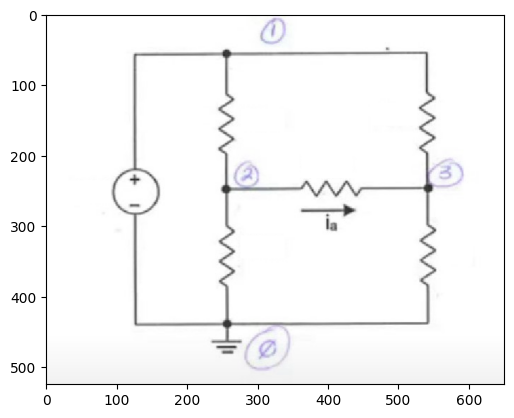

In [10]:
img = cv2.imread(IMAGE_PATH)
font = cv2.FONT_HERSHEY_DUPLEX
for i in range(len(result)):
    top_left = (result[i][0][0])
    bottom_right = (result[i][0][2])
    text = result[i][1]
    img = cv2.rectangle(img, top_left, bottom_right, (255, 255, 255), -1)
    # img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 5)
    # img = cv2.putText(img, text, top_left, font, .5, (0, 0, 0), 2, cv2.LINE_AA)
    
plt.imshow(img)
plt.show()

In [11]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [13]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

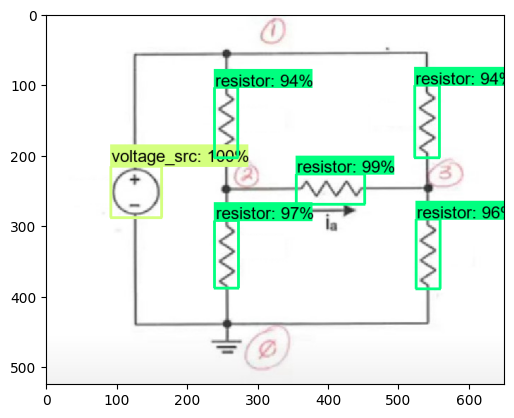

In [15]:
# img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.80,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

[['voltage_src', [216, 91, 288, 164]], ['resistor', [227, 354, 269, 452]], ['resistor', [293, 238, 388, 273]], ['resistor', [291, 524, 389, 559]], ['resistor', [101, 522, 203, 558]], ['resistor', [104, 238, 203, 272]]]


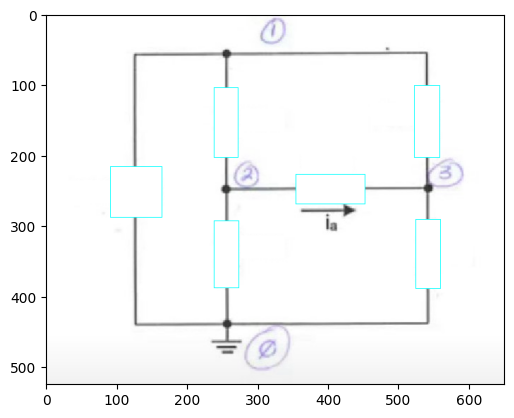

In [16]:
threshold = 0.8
device_bounding_boxes = []

img_height, img_width, _ = img.shape
for index, content in enumerate(detections['detection_boxes']):
    if detections['detection_scores'][index] > threshold:
        y_min, x_min, y_max, x_max = content
        y_min, x_min, y_max, x_max = np.float32(y_min), np.float32(x_min), np.float32(y_max), np.float32(x_max)
        y_min, x_min, y_max, x_max = y_min.item(), x_min.item(), y_max.item(), x_max.item()
        top_left = (int(x_min * img_width), int(y_min * img_height))
        bottom_right = (int(x_max * img_width), int(y_max * img_height))
        
        # Search points
        bounding_boxes_limits = ([int(y_min * img_height), int(x_min * img_width), int(y_max * img_height), int(x_max * img_width)])
        class_index = detections['detection_classes'][index]+label_id_offset
        device_bounding_boxes.append([category_index.get(class_index)['name'], bounding_boxes_limits])
        
        # Drawing rectangles
        img = cv2.rectangle(img, top_left, bottom_right, (255, 255, 255), -1)
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 255), 1)
print(device_bounding_boxes)
plt.imshow(img)
plt.show()

In [17]:
# import statistics as stat

# if img is not None:
#     cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# #     # without gaussian blur
# #     gray = np.float32(gray)
# #     dst = cv2.cornerHarris(gray, 2, 3, 0.04)
# #     dst = cv2.dilate(dst, None)
    
# #     # with gaussian blur
# #     gray = np.float32(gray)
# #     blur = cv2.GaussianBlur(gray, (5,5), 0)
# #     dst = cv2.cornerHarris(blur, 2, 3, 0.04)
# #     dst = cv2.dilate(dst, None)
    
#     # with bilateral blur
#     gray = np.float32(gray)
#     bilFilter = cv2.bilateralFilter(gray,9,75,75)
#     dst = cv2.cornerHarris(bilFilter, 2, 3, 0.04)
#     dst = cv2.dilate(dst, None)
    
#     img[dst > 0.01 * dst.max()] = [0, 0, 255]
    
#     # check coordinate of red pixels
#     lower_red = np.array([0,0,220])
#     upper_red = np.array([10,10,255])
#     mask = cv2.inRange(img, lower_red, upper_red)  
#     #get all non zero values
#     coord = cv2.findNonZero(mask)
    
#     plt.imshow(img)
#     plt.show()
# else:
#     print("image is not available")

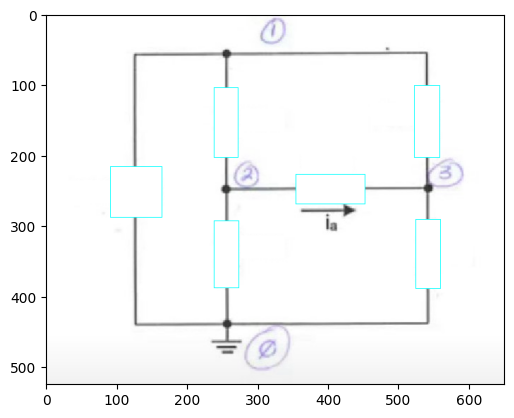

In [18]:
image_test = img
plt.imshow(image_test)
# plt.savefig('cir_6.jpg')
# cv2.imwrite('cir_6.jpg', img)
plt.show()

In [19]:
def x_correct_path(y_check_pt, x_check_pt):
    
    """
    x_check_pt += 5 or x_check_pt -= 5
    """
    y_min_check_pt = y_check_pt - 8 
    y_max_check_pt = y_check_pt + 8
    
    array = np.array(img[y_min_check_pt:y_max_check_pt, x_check_pt])
    path_exists = np.any(np.all(array == [255, 0, 0], axis=1))
    
    if path_exists:
        wire_color = [255, 0, 0]
        indices = np.where(np.all(array == wire_color, axis=1))[0]
        index = indices[0] if indices.size > 0 else None
        y_check_pt = y_min_check_pt + index
        
    else:
#         print("this is array=", array)
        min_values = array.min(axis=0)
        print(min_values)

        min_indices = array.argmin(axis=0)
        if np.all(min_indices == min_indices[0]):
            min_index = min_indices[0]
            y_check_pt = y_min_check_pt + min_index
            # print(min_index)
        else:
            raise Exception("Wrong Argument used")
    
    return y_check_pt 

In [20]:
def y_correct_path(y_check_pt, x_check_pt):
    """
    y_check_pt += 5 or y_check_pt -= 5
    
    """
    
    x_min_check_pt = x_check_pt - 8 
    x_max_check_pt = x_check_pt + 8
    
    array = np.array(img[y_check_pt, x_min_check_pt:x_max_check_pt])
    path_exists = np.any(np.all(array == [255, 0, 0], axis=1))
    
    if path_exists:
        wire_color = [255, 0, 0]
        indices = np.where(np.all(array == wire_color, axis=1))[0]
        index = indices[0] if indices.size > 0 else None
        x_check_pt = x_min_check_pt + index
        
    else:
#         print("this is array=", array)
        min_values = array.min(axis=0)
        print(min_values)

        min_indices = array.argmin(axis=0)
        # print("this indices=", min_indices)
        if np.all(min_indices == min_indices[0]):
            min_index = min_indices[0]
            x_check_pt = x_min_check_pt + min_index
            # print(min_index)
        else:
            raise Exception("Wrong Argument used")
    
    return x_check_pt 

In [21]:
def x_moving_direction(y_check_pt, x_check_pt, pos_direction = True):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[1] - x_check_pt:
            red = img[y_check_pt, x_check_pt + index][0]
            green = img[y_check_pt, x_check_pt + index][1]
            blue = img[y_check_pt, x_check_pt + index][2]
            # print(red, green, blue)
            
            if red == 255 and green == 0 and blue == 0:
                node_list.append([y_check_pt, x_check_pt + index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                img[y_check_pt, x_check_pt + index] = [255, 0, 0]
                index += 1
            else:
                x_check_pt = x_check_pt + index
                break
    else:
        index = x_check_pt
        while index > 0 or index < img.shape[1] - 1:
            red = img[y_check_pt, index][0]
            green = img[y_check_pt, index][1]
            blue = img[y_check_pt, index][2]
            # print(red, green, blue)
            
            if red == 255 and green == 0 and blue == 0:
                node_list.append([y_check_pt, index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                x_check_pt = index
                img[y_check_pt, x_check_pt] = [255, 0, 0]
                index -= 1
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt

In [22]:
def y_moving_direction(y_check_pt, x_check_pt, pos_direction = False):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[0] - y_check_pt:
            red = img[y_check_pt + index, x_check_pt][0]
            green = img[y_check_pt + index, x_check_pt][1]
            blue = img[y_check_pt + index, x_check_pt][2]
            
            if red == 255 and green == 0 and blue == 0:
                node_list.append([y_check_pt + index, x_check_pt])

            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                img[y_check_pt + index, x_check_pt] = [255, 0, 0]
                index += 1
            else:
                y_check_pt = y_check_pt + index
                break
    else:
        index = y_check_pt
        while index > 0 or index < img.shape[0] - 1:
            red = img[index, x_check_pt][0]
            green = img[index, x_check_pt][1]
            blue = img[index, x_check_pt][2]
            
            if red == 255 and green == 0 and blue == 0:
                node_list.append([index, x_check_pt])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                # array = np.array(img[38, xmin + min_indices[0]])
                y_check_pt = index
                img[y_check_pt, x_check_pt] = [255, 0, 0]
                index -= 1
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt

In [23]:
def check_path(img, x_check_pt, y_check_pt, testing = False):
    # Define the size of the region and offset
    region_size = 8
    offset = 10
    
    # Function to get the average RGB values for a region
    def get_avg_rgb(region):
        avg_color = np.mean(region, axis=(0,1))
        return avg_color

    # Extract regions further away and compute average RGB values for each direction
    left_region = img[y_check_pt - region_size//2:y_check_pt + region_size//2, x_check_pt - offset - region_size:x_check_pt - offset]
    avg_red_left, avg_green_left, avg_blue_left = get_avg_rgb(left_region)

    right_region = img[y_check_pt - region_size//2:y_check_pt + region_size//2, x_check_pt + offset:x_check_pt + offset + region_size]
    avg_red_right, avg_green_right, avg_blue_right = get_avg_rgb(right_region)

    up_region = img[y_check_pt - offset - region_size:y_check_pt - offset, x_check_pt - region_size//2:x_check_pt + region_size//2]
    avg_red_up, avg_green_up, avg_blue_up = get_avg_rgb(up_region)

    down_region = img[y_check_pt + offset:y_check_pt + offset + region_size, x_check_pt - region_size//2:x_check_pt + region_size//2]
    avg_red_down, avg_green_down, avg_blue_down = get_avg_rgb(down_region)

    # Check if the average color values exceed 200 for each channel
    left_blocked = avg_red_left > 200 and avg_green_left > 200 and avg_blue_left > 200
    right_blocked = avg_red_right > 200 and avg_green_right > 200 and avg_blue_right > 200
    up_blocked = avg_red_up > 200 and avg_green_up > 200 and avg_blue_up > 200
    down_blocked = avg_red_down > 200 and avg_green_down > 200 and avg_blue_down > 200

    if testing == True:
        
        # Color the regions in the image
        red_color = [0, 0, 255] # changed to blue 
        green_color = [255, 0, 0] # changed to red 

        if left_blocked:
            left_region[:,:] = red_color
        else:
            left_region[:,:] = green_color

        if right_blocked:
            right_region[:,:] = red_color
        else:
            right_region[:,:] = green_color

        if up_blocked:
            up_region[:,:] = red_color
        else:
            up_region[:,:] = green_color

        if down_blocked:
            down_region[:,:] = red_color
        else:
            down_region[:,:] = green_color

        # Display the updated image
        plt.imshow(img)
        plt.show()

    # Combine the blocked directions to provide a comprehensive response
    blocked_directions = []

    if left_blocked:
        blocked_directions.append("left")
    if right_blocked:
        blocked_directions.append("right")
    if up_blocked:
        blocked_directions.append("up")
    if down_blocked:
        blocked_directions.append("down")

    if not blocked_directions:
        return None  # No direction is blocked
    
    return blocked_directions


In [24]:
# Recursive function to navigate through the grid.
def navigate(img, x_check_pt, y_check_pt, visited, prev_direction=None, testing = False):
    
    # Check if current position is out of bounds or in an invalid position.
    if x_check_pt < 0 or x_check_pt > img.shape[1] - 1 or y_check_pt < 0 or y_check_pt > img.shape[0] - 1:
        raise Exception("Exceed the image boundaries")
    
    # If we've been here before, don't revisit.
    if (x_check_pt, y_check_pt) in visited:
        return ("its existed")
    
    visited.add((x_check_pt, y_check_pt))

    # Check for blocked directions.
    blocked_directions = set()
    if prev_direction == 'down':  # If we came from below, we don't want to go back.
        blocked_directions.add('up')
    elif prev_direction == 'up':
        blocked_directions.add('down')
    elif prev_direction == 'left':
        blocked_directions.add('right')
    elif prev_direction == 'right':
        blocked_directions.add('left')

    # check for blocked directions
    checked_direction = check_path(img, x_check_pt, y_check_pt, testing)
    print("checked_direction", checked_direction)
    blocked_directions.update(checked_direction)
    print("prev_direction", prev_direction)
    print("blocked_directions", blocked_directions)

    path = [(x_check_pt, y_check_pt)]
    directions = ['up', 'right', 'down', 'left']
    for direction in directions:
        if direction not in blocked_directions:
            
            print("direction", direction)
            if direction == 'up':
                x_check_pt = y_correct_path(y_check_pt - 5, x_check_pt)
                x_check_pt, y_check_pt = y_moving_direction(y_check_pt, x_check_pt, pos_direction = False)
            
            elif direction == 'left':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt - 5)
                x_check_pt, y_check_pt = x_moving_direction(y_check_pt, x_check_pt, pos_direction = False)
                
            elif direction == 'right':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt + 5)
                x_check_pt, y_check_pt = x_moving_direction(y_check_pt, x_check_pt, pos_direction = True)
                
            elif direction == 'down':
                x_check_pt = y_correct_path(y_check_pt + 5, x_check_pt)
                x_check_pt, y_check_pt = y_moving_direction(y_check_pt, x_check_pt, pos_direction = True)
                
                
            # Recursively navigate from the new position.
            path += navigate(img, x_check_pt, y_check_pt, visited, direction)

    return path

In [25]:
print(device_bounding_boxes)

[['voltage_src', [216, 91, 288, 164]], ['resistor', [227, 354, 269, 452]], ['resistor', [293, 238, 388, 273]], ['resistor', [291, 524, 389, 559]], ['resistor', [101, 522, 203, 558]], ['resistor', [104, 238, 203, 272]]]


In [26]:
def component_orientation(comp_orientation):
    """
    orientation of the device is verticle or horizontal
    if its verticle assume that ymin is the anode 
    if its horizontal assume that xmin is the anode
    """
    
    ymin, xmin, ymax, xmax = comp_orientation
    vertically_connected = check_path(img, int((xmax + xmin)/2),  ymin)
    horizontally_connected = check_path(img, xmin, int((ymax + ymin)/2))
    
    directions = ['up', 'right', 'down', 'left']
    for direction in directions:
        if direction not in vertically_connected:
            anode_starting_pts = ymin - 1, int((xmax + xmin)/2)
            cathode_starting_pts = ymax + 1, int((xmax + xmin)/2)
            orientation = 'V'
            
        elif direction not in horizontally_connected: 
            anode_starting_pts = int((ymax + ymin)/2), xmin - 1
            cathode_starting_pts = int((ymax + ymin)/2), xmax + 1
            orientation = 'H'
            
    return anode_starting_pts, cathode_starting_pts, orientation

215 127
[106 106 106]
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up
[106 106 106]


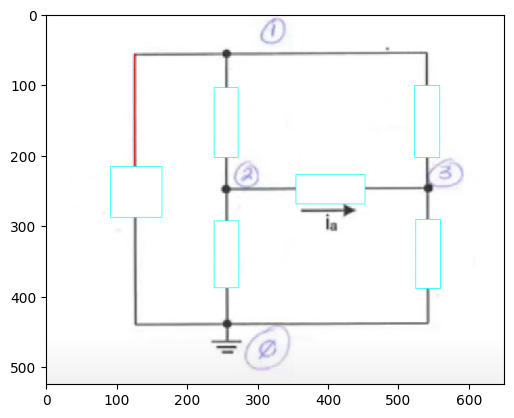

checked_direction ['left', 'up']
prev_direction up
blocked_directions {'left', 'up', 'down'}
direction right
[129 129 129]


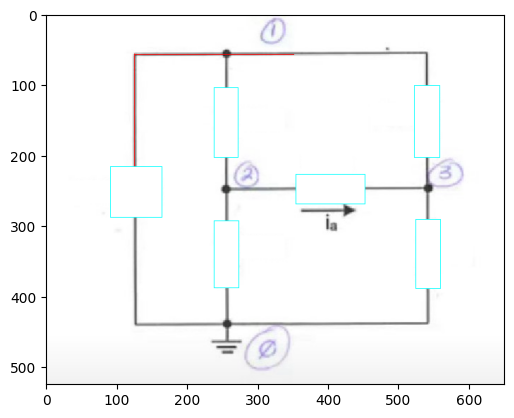

checked_direction ['up', 'down']
prev_direction right
blocked_directions {'left', 'up', 'down'}
direction right
[112 112 112]


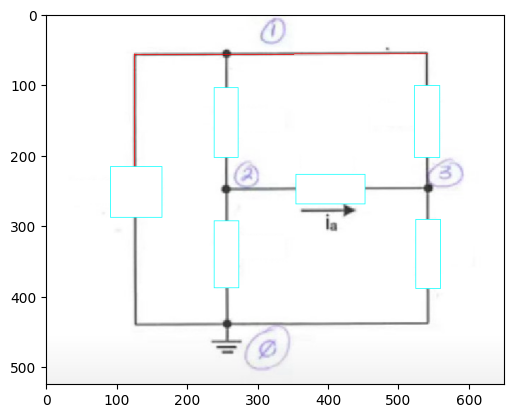

checked_direction ['right', 'up']
prev_direction right
blocked_directions {'left', 'up', 'right'}
direction down
[75 75 75]


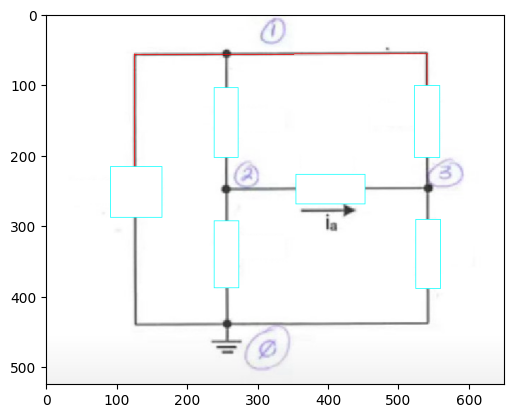

checked_direction ['left', 'right', 'down']
prev_direction down
blocked_directions {'left', 'up', 'down', 'right'}
(125, 215)
(125, 56)
(352, 57)
(542, 56)
(540, 101)
248 353
[114 114 114]
checked_direction ['right', 'up', 'down']
prev_direction None
blocked_directions {'up', 'down', 'right'}
direction left
[115 115 115]


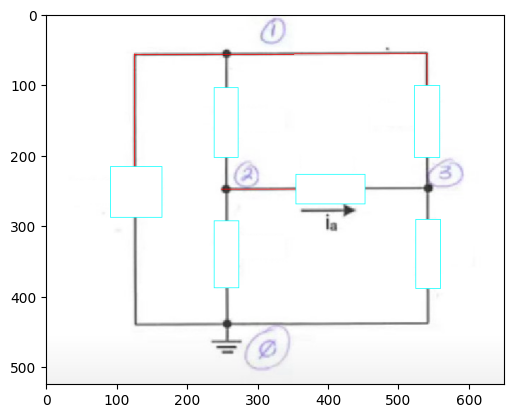

checked_direction ['left', 'up', 'down']
prev_direction left
blocked_directions {'left', 'up', 'down', 'right'}
(353, 248)
(248, 248)
292 255
[109 109 109]
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up
[110 110 110]


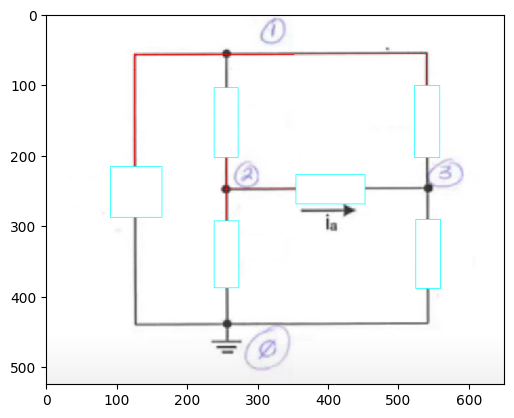

checked_direction ['left', 'right', 'up']
prev_direction up
blocked_directions {'left', 'up', 'down', 'right'}
(256, 292)
(256, 204)
290 541
[74 74 74]
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up
[79 79 79]


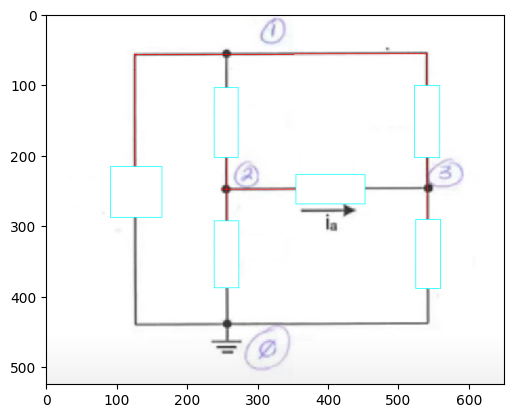

checked_direction ['left', 'right', 'up']
prev_direction up
blocked_directions {'left', 'up', 'down', 'right'}
(541, 290)
(541, 204)
100 540
103 255
[107 107 107]
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up
[107 107 107]


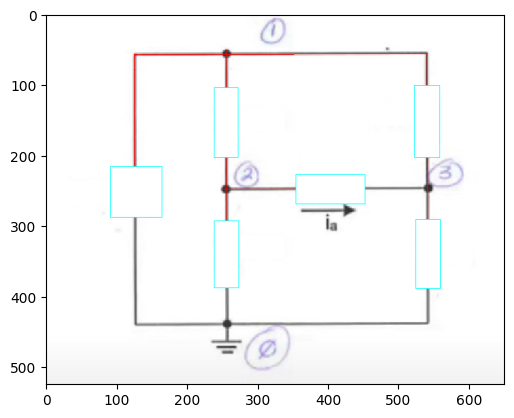

checked_direction ['left', 'right', 'up']
prev_direction up
blocked_directions {'left', 'up', 'down', 'right'}
(256, 103)
(256, 50)


In [27]:
node_list = []
for index, elements in enumerate(device_bounding_boxes):
    anode_starting_pts, _ , orienatation = component_orientation(device_bounding_boxes[index][1])
    y_check_pt, x_check_pt = anode_starting_pts
    print(y_check_pt, x_check_pt)
    
    #check if the starting pts is red
    if orienatation == "V":
        x_check_pt = y_correct_path(y_check_pt, x_check_pt)
        if np.array_equal(img[y_check_pt, x_check_pt], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt, y_check_pt
            visited = set()
            path = navigate(img, start_x, start_y, visited, prev_direction=None)
            for position in path:
                print(position)
    
    elif orienatation == "H":
        y_check_pt = x_correct_path(y_check_pt, x_check_pt)
        if np.array_equal(img[y_check_pt, x_check_pt], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt, y_check_pt
            visited = set()
            path = navigate(img, start_x, start_y, visited, prev_direction=None)
            for position in path:
                print(position)
    

In [28]:
node_list

[[57, 125], [56, 540], [248, 256], [57, 256]]

In [29]:
# # Unpack nodes for plotting
# y_vals, x_vals = zip(*node_list)

# # Plot the image
# plt.imshow(img.astype(np.uint8))

# # Plot the nodes (in red color with 'o' marker)
# plt.scatter(x_vals, y_vals, c='red', marker='o')

# plt.show()

In [30]:
# go through all the paths that is red [255, 0, 0] and check if there is node [y,x] that is in node list [[57, 125], [56, 540], [248, 256], [57, 256]]

In [31]:
node_list[0]

[57, 125]

In [32]:
y, x = node_list[0]

In [ ]:
def x_moving_direction_node_checking(y_check_pt, x_check_pt, pos_direction = True):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[1] - x_check_pt:
            red = img[y_check_pt, x_check_pt + index][0]
            green = img[y_check_pt, x_check_pt + index][1]
            blue = img[y_check_pt, x_check_pt + index][2]
            # print(red, green, blue)
            
            if [y_check_pt, x_check_pt + index] in nodelist:
                node_device.append([y_check_pt, x_check_pt + index])
                
            if red == 255 and green == 0 and blue == 0:
                index += 1
            else:
                x_check_pt = x_check_pt + index
                break
    else:
        index = x_check_pt
        while index > 0 or index < img.shape[1] - 1:
            red = img[y_check_pt, index][0]
            green = img[y_check_pt, index][1]
            blue = img[y_check_pt, index][2]
            # print(red, green, blue)
            
            if [y_check_pt, index] in nodelist:
                node_device.append([y_check_pt, index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                x_check_pt = index
                index -= 1
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt

In [ ]:
def y_moving_direction_node_checking(y_check_pt, x_check_pt, pos_direction = False):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[0] - y_check_pt:
            red = img[y_check_pt + index, x_check_pt][0]
            green = img[y_check_pt + index, x_check_pt][1]
            blue = img[y_check_pt + index, x_check_pt][2]
            
            if [y_check_pt, index] in nodelist:
                node_device.append([y_check_pt, index])

            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                img[y_check_pt + index, x_check_pt] = [255, 0, 0]
                index += 1
            else:
                y_check_pt = y_check_pt + index
                break
    else:
        index = y_check_pt
        while index > 0 or index < img.shape[0] - 1:
            red = img[index, x_check_pt][0]
            green = img[index, x_check_pt][1]
            blue = img[index, x_check_pt][2]
            
            if red == 255 and green == 0 and blue == 0:
                node_list.append([index, x_check_pt])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                # array = np.array(img[38, xmin + min_indices[0]])
                y_check_pt = index
                img[y_check_pt, x_check_pt] = [255, 0, 0]
                index -= 1
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt